# Prepare Custom Tokenization Rules

In [1]:
import spacy

nlp = spacy.load('de_dep_news_trf')
# Make sure compounds ("BRAF-Mutation") are tokenized
infixes = nlp.Defaults.infixes + [r'([-+/–])']
nlp.tokenizer.infix_finditer = spacy.util.compile_infix_regex(infixes).finditer

/Users/phlobo/miniconda3/envs/temp/lib/python3.10/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/Users/phlobo/miniconda3/envs/temp/lib/python3.10/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]
/Users/phlobo/miniconda3/envs/temp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Store for training NER model using the same tokenizer
nlp.to_disk("spacy_ner/molecular_tokenizer")

# Train Model 

- `cd spacy_ner`
- `./run_training.sh 1 ../data/molecular_2024_04_03 GerMedBERT/medbert-512 spancat_molecular`

# Load Dataset

In [1]:
from pathlib import Path
data_path = Path('data/molecular_2024_04_03/')

In [2]:
import spacy
from spacy_ner import chunk_and_ngram_suggester
cp = '2024-04-03_19-50-09-cuda-5'
#cp = '2024-04-03_21-41-57-cuda-1'
model = spacy.load(f'/home/Florian.Borchert/workspace/ggponc/spacy_ner/training/{cp}/model-best/')

/home/Florian.Borchert/miniconda3/envs/ggponc/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/Florian.Borchert/miniconda3/envs/ggponc/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
SPLITS = ['train', 'validation', 'test']

In [3]:
from xmen.data import from_spacy
from spacy.tokens import DocBin

docs = {}

for split in SPLITS:
    db = DocBin(store_user_data=True).from_disk(data_path / f'{split}.spacy')
    docs[split] = list(db.get_docs(model.vocab))

/Users/phlobo/miniconda3/envs/temp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/phlobo/miniconda3/envs/temp/lib/python3.10/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/Users/phlobo/miniconda3/envs/temp/lib/python3.10/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


NameError: name 'model' is not defined

In [ ]:
all_docs = sum(docs.values(), [])

In [ ]:
def get_genes(docs):
    return [e.text for d in docs for e in d.spans['entities'] if e.label_ == 'Gene or Protein']

def get_variants(docs):
    return [e.text for d in docs for e in d.spans['entities'] if e.label_ == 'Variant']

In [ ]:
for split in SPLITS:
    d = docs[split]
    print(split, 'Docs', len(d), '#Genes', len(get_genes(d)), '#Variants', len(get_variants(d)))
print('Total', 'Docs', len(all_docs), '#Genes', len(get_genes(all_docs)), '#Variants', len(get_variants(all_docs)))

train Docs 239 #Genes 1766 #Variants 633
validation Docs 52 #Genes 407 #Variants 110
test Docs 52 #Genes 377 #Variants 106
Total Docs 343 #Genes 2550 #Variants 849


## Types / Unique Names

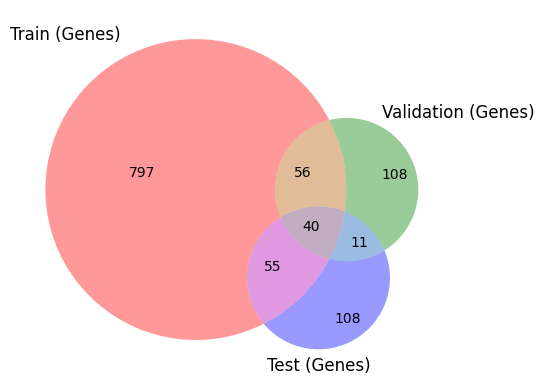

In [ ]:
from matplotlib_venn import venn3

train_genes = set(get_genes(docs['train']))
val_genes = set(get_genes(docs['validation']))
test_genes = set(get_genes(docs['test']))

venn3([train_genes, val_genes, test_genes], ['Train (Genes)', 'Validation (Genes)', 'Test (Genes)'])

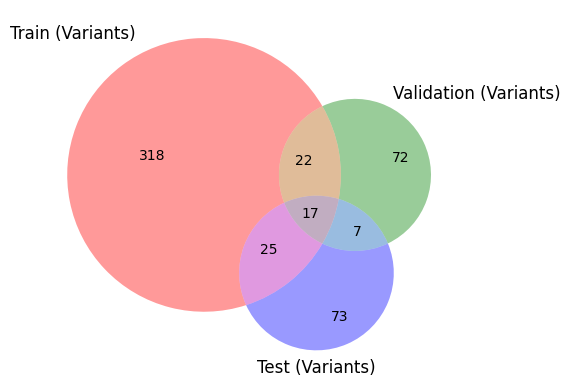

In [ ]:
train_vars = set(get_variants(docs['train']))
val_vars = set(get_variants(docs['validation']))
test_vars = set(get_variants(docs['test']))

from matplotlib_venn import venn3
venn3([train_vars, val_vars, test_vars], ['Train (Variants)', 'Validation (Variants)', 'Test (Variants)'])

## Show annotation example

In [4]:
from spacy import displacy
def show(d):
    displacy.render(d, style='span', options={'spans_key' : 'entities'})
show(all_docs[13])

NameError: name 'all_docs' is not defined

In [25]:
import pandas as pd
pd.Series([len(g.split(' ')) for g in get_genes(all_docs)]).value_counts()

1    2373
2      91
3      24
4      10
5       6
Name: count, dtype: int64

In [26]:
pd.Series([len(g.split(' ')) for g in get_variants(all_docs)]).value_counts()

1     572
2     168
3     133
4      30
5      28
6       9
8       7
7       5
12      2
11      1
Name: count, dtype: int64

# Performance Evaluation

In [81]:
from tqdm.auto import tqdm
from xmen.data import from_spacy
from xmen.evaluation import evaluate, error_analysis

In [72]:
test_docs = docs['test']

In [75]:
gt_test = from_spacy(test_docs, span_key='entities', doc_id_key='file')

In [78]:
pred_test = list(model.pipe((t.text for t in tqdm(test_docs)), batch_size=16))

  0%|          | 0/52 [00:00<?, ?it/s]

In [79]:
for t, pt in zip(test_docs, pred_test):
    pt.user_data['file'] = t.user_data['file']

In [80]:
pred_test_ds = from_spacy(pred_test, span_key='entities', doc_id_key='file')

In [82]:
evaluate(gt_test, pred_test_ds, ner_only=True, metrics=['strict', 'partial'])

{'strict': {'precision': 0.8951406649616368,
  'recall': 0.7246376811594203,
  'fscore': 0.8009153318077803,
  'ptp': 350,
  'fp': 41,
  'rtp': 350,
  'fn': 133,
  'n_docs_system': 52,
  'n_annos_system': 391,
  'n_docs_gold': 52,
  'n_annos_gold': 483},
 'partial': {'precision': 0.9359901021412946,
  'recall': 0.7448622171406905,
  'fscore': 0.8295596879094341,
  'ptp': 365.9721299372462,
  'fp': 25.027870062753777,
  'rtp': 359.7684508789535,
  'fn': 123.2315491210465,
  'n_docs_system': 52,
  'n_annos_system': 391,
  'n_docs_gold': 52,
  'n_annos_gold': 483}}

In [84]:
ea = error_analysis(gt_test, pred_test_ds, tasks=['ner'])
ea.ner_match_type.value_counts()

ner_match_type
tp     350
fn     110
be      22
fp      17
lbe      9
Name: count, dtype: int64

In [87]:
ea.query('ner_match_type == "fn"')

,_word_len,_abbrev,gt_start,gt_end,gt_text,gold_type,pred_start,pred_end,pred_text,pred_type,ner_match_type,corpus_id,document_id
0,7.0,False,292.0,357.0,[genetisches Rearrangement der Anaplastischen ...,Variant,NaN,NaN,None,None,fn,None,29_adulte-weichgewebesarkome_0393.txt
10,3.0,False,329.0,352.0,[Mutationen im FANCC-Gen],Variant,NaN,NaN,None,None,fn,None,10_pankreaskarzinom_0079.txt
12,1.0,False,3138.0,3163.0,[Matrix-Metalloproteinasen],Gene or Protein,NaN,NaN,None,None,fn,None,28_komplementaermedizin_0272.txt
17,1.0,False,3417.0,3434.0,[Metalloproteinase],Gene or Protein,NaN,NaN,None,None,fn,None,28_komplementaermedizin_0272.txt
23,1.0,False,3753.0,3758.0,[Nrf2)],Gene or Protein,NaN,NaN,None,None,fn,None,28_komplementaermedizin_0272.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,2.0,True,56.0,81.0,[VEGF-Rezeptor-Isoformen 2],Gene or Protein,NaN,NaN,None,None,fn,None,12_nierenzellkarzinom_0186.txt
497,1.0,False,86.0,87.0,[3],Gene or Protein,NaN,NaN,None,None,fn,None,12_nierenzellkarzinom_0186.txt
504,1.0,True,730.0,733.0,[IFN],Gene or Protein,NaN,NaN,None,None,fn,None,12_nierenzellkarzinom_0186.txt
505,1.0,True,946.0,949.0,[INF],Gene or Protein,NaN,NaN,None,None,fn,None,12_nierenzellkarzinom_0186.txt


In [104]:
mol_path_1 = """
Im Panel werden folgende Gene ganz oder teilweise untersucht:
 
 A) Amplicon-basierter Nachweis von DNA-Varianten in Mutationshotspots in folgenden Genen:
 AKT1, AKT2, AKT3, ALK, AR, ARAF, AXL, BRAF, BTK, CBL, CCND1, CDK4, CDK6, CHEK2, CSF1R, CTNNB1, DDR2, EGFR, ERBB3, ERBB2, ERBB4, ERCC2, ESR1, EZH2, FGFR1, FGFR2, FGFR3, FGFR4, FLT3, FOXL2, GATA2, GNA11, GNAQ, GNAS, H3F3A, HIST1H3B, HNF1A, HRAS, IDH1, IDH2, JAK1, JAK2, JAK3, KDR, KIT, KNSTRN, KRAS, MAGOH, MAP2K1, MAP2K2, MAP2K4, MAPK1, MAX, MDM4, MED12, MET, MTOR, MYC, MYCN, MYD88, NFE2L2, NRAS, NTRK1, NTRK2, PDGFRA, PDGFRB, PIK3CA, PIK3CB, PPP2R1A, PTPN11, RAC1, RAF1, RET, RHEB, RHOA, ROS1, SF3B1, SMAD4, SMO, SPOP, SRC, STAT3, TERT, TOP1, U2AF1, XPO1
 
 B) Amplicon-basierter Nachweis von DNA-Varianten in der kompletten kodierenden Sequenz in folgenden Genen:
 ARID1A, ATM, ATR, ATRX, BAP1, BRCA1, BRCA2, CDK12, CDKN1B, CDKN2A, CDKN2B, CHEK1, CREBBP, FANCA, FANCD2, FANCI, FBXW7, MLH1, MRE11A, MSH2, MSH6, NBN, NF1, NF2, NOTCH1, NOTCH2, NOTCH3, PALB2, PIK3R1, PMS2, POLE, PTCH1, PTEN, RAD50, RAD51, RAD51B, RAD51C, RAD51D, RB1, RNF43, SETD2, SLX4, SMARCA4, SMARCB1, STK11, TP53, TSC1, TSC2
 
 C) Amplicon-basierter  Nachweis von Änderungen der Genkopienzahl in folgenden Genen:
 AKT1, AKT2, AKT3, ALK, AR, AXL, BRAF, CCND1, CCND2, CCND3, CCNE1, CDK2, CDK4, CDK6, CDKN2A, CDKN2B, EGFR, ERBB2, ESR1, FGF19, FGF3, FGFR1, FGFR2, FGFR3, FGFR4, FLT3, IGF1R, KIT, KRAS, MDM2, MDM4, MET, MYC, MYCL, MYCN, NTRK1, NTRK2, NTRK3, PDGFRA, PDGFRB, PIK3CA, PIK3CB, PPARG, RICTOR, TERT, TSC1, TSC2
 Pathologisch-anatomische Begutachtung:
 I. Eine Gallenblase mit mäßiger chronischer und florider Entzündung.
"""

In [105]:
show(model(mol_path_1))

In [106]:
mol_path_2 = """
HER2-Statusbestimmung:
Es kamen für den Genlocus 17q12 sowie für die Centromerregion des Chromosoms 17 (CEP17) spezifische Sonden zum Einsatz. 
Es wurden > 50 Tumorzellkerne ausgezählt. 
Es zeigten sich ein bis drei Signale für 17q12 (HER2/neu) und ein bis drei Signale für CEP17. Die 17q12/CEP17 Ratio lag bei < 2,0:1.

Folgende Varianten wurden nachgewiesen:
 
Gen Variante    Frequenz    Lesetiefe   Bewertung

KRAS    chr12:25398284:NM_033360.4:Exon2:c.35G>T:p.G12V 8,7%    2.235 AMP Tier I

Aktivierende Hotspotmutation

JAK2    chr9:5073770:NM_004972.4:Exon14:c.1849G>T:p.V617F   20,4%   831 AMP Tier I

Aktivierende Hotspotmutation, möglicherweise aus den Blutgefäßen im Tumor. Ist eine P.vera oder MPN bekannt?
 
Kopienzahlveränderungen:    KEIN Anhalt für das Vorliegen einer Kopienzahlveränderung eines der aufgeführten Gene
"""

show(model(mol_path_2))